# Import Required Libraries


In [1]:
import os
import shutil
import plotly
import numpy as np 
import pandas as pd
import tensorflow as tf 
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pydot

# Reading data and augmentation
- Reading the target class values
- Reading data from folders and rescale


In [2]:
# Get classes from directory names
class_names = os.listdir('data/train')
print(class_names)

['Benign', 'Early', 'Pre', 'Pro']


## Define a function that takes in a dataframe, and integers max_samples, min_samples.
it uses the function trim to set the maximum number of samples in a class defined by the string column to max_samples. if the number of samples is less than min_samples the class is eliminated from the dataset. If some classes have less than max_samples, then augmented images are created for that class and stored in the working_dir so the class will have max_samples of images. After augmentation an aug_df is created for the augmented images in the working_dir. The aug_df is then merged with the original train_df to produce a new train_df that has exactly max_sample images in each class thus creating a balanced training set.


In [3]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column) 
    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.2,
                                  height_shift_range=0.2, zoom_range=0, fill_mode='wrap')
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 



## Define a function that takes in a dataframe df, and integer max_size and a string column.
Returns a dataframe where the number of samples for any class specified by column is limited to max samples

In [4]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

## Define preprocess function to read in image file and create dataframes

In [5]:
def preprocess (sdir):
    categories=['train', 'test', 'valid']
    for category in categories:
        catpath=os.path.join(sdir, category)
        filepaths=[]
        labels=[]    
        classlist=os.listdir(catpath)
        for klass in classlist:
            classpath=os.path.join(catpath,klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        if category == 'train':
            train_df=pd.concat([Fseries, Lseries], axis=1)            
        elif category =='test':
            test_df=pd.concat([Fseries, Lseries], axis=1) 
        else:
            valid_df= pd.concat([Fseries, Lseries], axis=1)     
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount < tecount :         
        msg='** WARNING ** number of classes in training set is less than the number of classes in test set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg='This will throw an error in either model.evaluate or model.predict'
        print_in_color(msg, (255,0,0), (55,65,80))
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set' 
        print_in_color(msg, (255,0,0), (55,65,80))
        msg=' this will throw an error in model.fit'
        print_in_color(msg, (255,0,0), (55,65,80))
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount) 
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')
    msg='\nBelow is image count per class to evaluate train_df balance'
    print_in_color(msg, (0,255,255),(55,65,80))
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df
    


## Define a function to print text in RGB foreground and background colors


In [6]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [7]:
sdir=r'./data-orig'
train_df, test_df, valid_df= preprocess(sdir)

train_df length:  2856   test_df length:  200   valid_df length:  200

Below is image count per class to evaluate train_df balance

[885, 863, 704, 404]


#### Balance Data Set
Limit maximum samples in a class to 150 samples. Create augmented images for under represented classes so all classes in training set have 400 samples

In [8]:
# max_samples=400
# min_samples= 0
column='labels'
working_dir = r'./'
img_size=(224,224)
# train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

#### **The train_df dataframe is now balanced with 400 samples per class**



## Create train, test and validation generators

In [9]:
img_shape = img_size + (3,) # Add a third dimension for RGB channel
print(img_shape)
batch_size=25
length=len(test_df)
test_batch_size=25  
test_steps=int(length/test_batch_size)
print (f'test batch size: {test_batch_size}, test steps: {test_steps}')

def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required

trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)

msg='                                                               for the training generator'
print(msg, '\r', end='') 
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='                                                               for the test generator'
print(msg, '\r', end='') 
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
msg='                                                               for the validation generator'
print(msg, '\r', end='')
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))
labels=test_gen.labels


(224, 224, 3)
test batch size: 25, test steps: 8
Found 2856 validated image filenames belonging to 4 classes.   for the training generator 
Found 200 validated image filenames belonging to 4 classes.    for the test generator 
Found 200 validated image filenames belonging to 4 classes.    for the validation generator 


### Let's see some cells


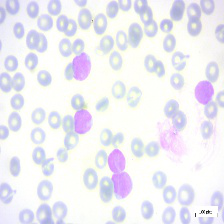
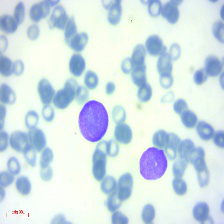
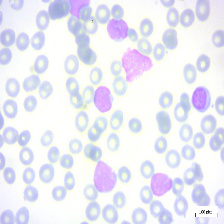
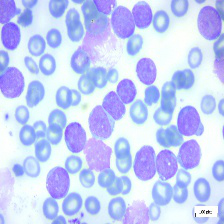
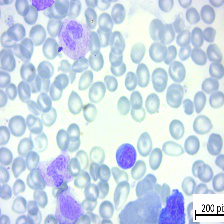
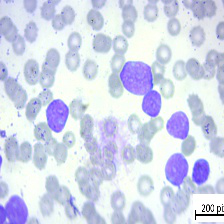
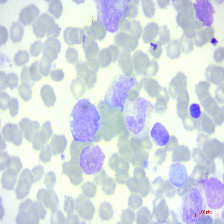
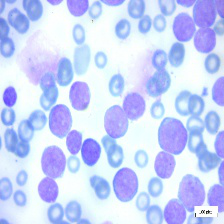
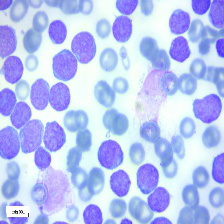
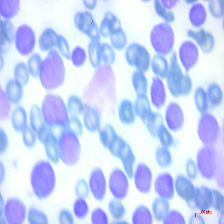
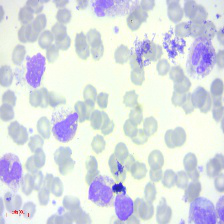
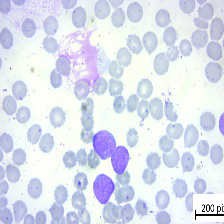
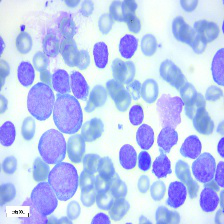
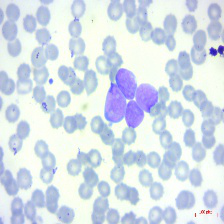
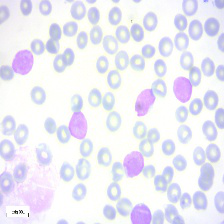
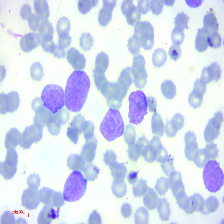

In [10]:
img, label = train_gen.next()
rows,cols = 4,4
fig = make_subplots(rows=rows, cols=cols,horizontal_spacing=0.05,subplot_titles=[class_names[np.argmax(label[i])] for i in range(rows*cols)])
indx=0
for i in range(rows):
    for j in range(cols):
        fig.add_trace(px.imshow(img[indx]).data[0],i+1,j+1)
        indx+=1
        fig.update_layout(width=1000,height=1000)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
fig.show()

# Model - EfficientNetV2L

In [11]:
model_name='EfficientNetV2L'

# Create a base model from the pre-trained EfficientNetV2L
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=img_shape, include_top=False) 
# Make model trainable
base_model.trainable = True

In [12]:
inputs = keras.Input(shape=img_shape) # Input layer

x = base_model(inputs) # EfficientNetV2L
x = layers.GlobalMaxPooling2D()(x) # Pooling layer
x = layers.Dropout(0.1)(x) # Dropout layer
 
outputs = Dense(class_count, activation = 'softmax')(x) # Classification layer

fine_tune_at = 1 # Update parameters starting from layer 1
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True

# Build the model
model = keras.Model(inputs, outputs)


In [13]:
# Print out a summary of the model created.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 117,751,972
Trainable params: 117,239,396
Non-t

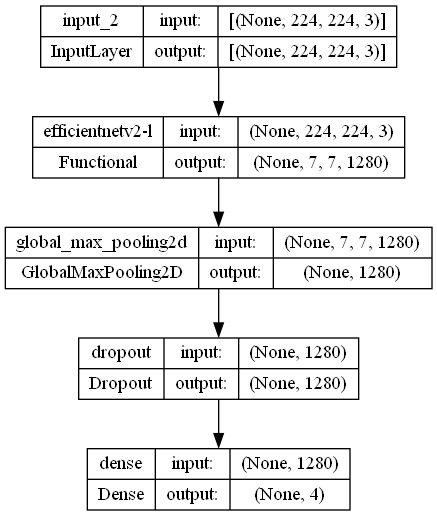

In [14]:
# Plot the model layers' dependency graph and each layer's input-output shape.
keras.utils.plot_model(model, show_shapes=True)

## Train model

Epoch 1/5
115/115 [==============================] - 44s 228ms/step - loss: 0.2270 - tp: 2688.0000 - fp: 143.0000 - tn: 8425.0000 - fn: 168.0000 - accuracy: 0.9440 - precision: 0.9495 - recall: 0.9412 - SpecificityAtSensitivity: 0.9985 - auc: 0.9883 - prc: 0.9777 - val_loss: 0.1221 - val_tp: 188.0000 - val_fp: 8.0000 - val_tn: 592.0000 - val_fn: 12.0000 - val_accuracy: 0.9450 - val_precision: 0.9592 - val_recall: 0.9400 - val_SpecificityAtSensitivity: 1.0000 - val_auc: 0.9969 - val_prc: 0.9917
Epoch 2/5
115/115 [==============================] - 23s 199ms/step - loss: 0.0531 - tp: 2805.0000 - fp: 46.0000 - tn: 8522.0000 - fn: 51.0000 - accuracy: 0.9828 - precision: 0.9839 - recall: 0.9821 - SpecificityAtSensitivity: 0.9996 - auc: 0.9988 - prc: 0.9970 - val_loss: 0.0657 - val_tp: 197.0000 - val_fp: 3.0000 - val_tn: 597.0000 - val_fn: 3.0000 - val_accuracy: 0.9850 - val_precision: 0.9850 - val_recall: 0.9850 - val_SpecificityAtSensitivity: 0.9983 - val_auc: 0.9962 - val_prc: 0.9908
Epoch

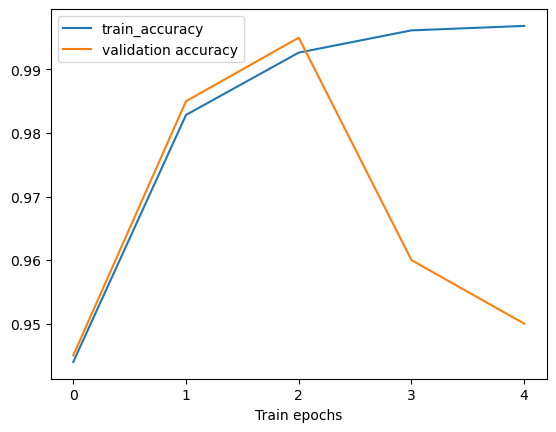

In [15]:
# Specify metrics, loss function, and optimizer 
# define evaluation metics
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
#       keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'), 
      keras.metrics.SpecificityAtSensitivity(0.5,name='SpecificityAtSensitivity'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

loss = 'categorical_crossentropy' # Better performance than categorical_crossentropy
# optimizer = keras.optimizers.Adam
optimizer = Adamax

# Create learning rates for two phases of training 
learning_rates = 0.001

# Setting the number of training epochs
training_epochs = 5

def print_info( test_gen, preds):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index) 
    tests=len(preds)
    acc= (1-errors/tests) *100

    y_true= np.array(labels)        
    y_pred=np.array(y_pred)

    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    return acc/100

# Compile the model
model.compile(
    optimizer=optimizer(learning_rates),
    loss=loss,
    metrics=metrics,
)

# Train the model
history = model.fit(
    train_gen,
    epochs=training_epochs,
    validation_data = valid_gen
)

# Retrieve the training metrics (after each train epoch)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(training_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [16]:
fig = make_subplots(rows=4, cols=2,subplot_titles=("Loss", "Accuracy","Precision","Recall","AUC","PRC","True Positive","SpecificityAtSensitivity"))
fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'),1,1)
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'),1,1)
fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name='Train Accuracy'),1,2)
fig.add_trace(go.Scatter(y=history.history['val_accuracy'],mode='lines', name='Validation Accuracy'),1,2)
fig.add_trace(go.Scatter(y=history.history['precision'], mode='lines', name='Train precision'),2,1)
fig.add_trace(go.Scatter(y=history.history['val_precision'],mode='lines', name='Validation precision'),2,1)
fig.add_trace(go.Scatter(y=history.history['recall'], mode='lines', name='Train recall'),2,2)
fig.add_trace(go.Scatter(y=history.history['val_recall'],mode='lines', name='Validation recall'),2,2)
fig.add_trace(go.Scatter(y=history.history['auc'], mode='lines', name='Train auc'),3,1)
fig.add_trace(go.Scatter(y=history.history['val_auc'],mode='lines', name='Validation auc'),3,1)
fig.add_trace(go.Scatter(y=history.history['prc'], mode='lines', name='Train prc'),3,2)
fig.add_trace(go.Scatter(y=history.history['val_prc'],mode='lines', name='Validation prc'),3,2)
fig.add_trace(go.Scatter(y=history.history['tp'], mode='lines', name='Train tp'),4,1)
fig.add_trace(go.Scatter(y=history.history['val_tp'],mode='lines', name='Validation tp'),4,1)
fig.add_trace(go.Scatter(y=history.history['SpecificityAtSensitivity'], mode='lines', name='Train SpecificityAtSensitivity'),4,2)
fig.add_trace(go.Scatter(y=history.history['val_SpecificityAtSensitivity'],mode='lines', name='Validation SpecificityAtSensitivity'),4,2)

fig.update_xaxes(title_text="Epoch", row=4, col=1)
fig.update_xaxes(title_text="Epoch", row=4, col=2)
fig.show()

## Test model

In [17]:
preds=model.predict(test_gen) 
acc=print_info(test_gen, preds) 

8/8 [==============================] - 3s 70ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

      Benign     1.0000    0.9600    0.9796        50
       Early     0.9615    1.0000    0.9804        50
         Pre     1.0000    1.0000    1.0000        50
         Pro     1.0000    1.0000    1.0000        50

    accuracy                         0.9900       200
   macro avg     0.9904    0.9900    0.9900       200
weighted avg     0.9904    0.9900    0.9900       200

